### Load packages

In [1]:
from user_setup import *
from gst_tools import gst_utils as utils
from gst_tools import constants
import pandas as pd

### Load data

In [2]:
# Data selection

if data == 'emissions':
    if extrapol:
        raw_data_fname = primap_extrap_fname
    else:
        raw_data_fname = primap_no_extrap_fname
else:
    raw_data_fname = bp_world_energy_panel_fname

In [3]:
# Data loading

raw_data = utils.load_data(constants.input_folder, raw_data_fname)

Reading input-data/Guetschow-et-al-2021-PRIMAP-hist_v2.3.1_20-Sep_2021.csv


### Reorganise and filter data

In [4]:
# Reorganise dataset for processing

if data == 'emissions':
    renamed_data = utils.rename_primap(raw_data)
elif data == 'energy':
    renamed_data = utils.rename_bp(raw_data)
else:
    print('Error. Please provide a valida dataset type, either "emissions" or "energy".')

In [5]:
#renamed_data[['Country', 'year', 'electbyfuel_ren_power']].loc[(renamed_data['Country'] == 'Canada')]
#ren_power_twh
#ren_power_twh_net
#

#What is included in renewables? In ren_power_twh, hydro is not included
# renewables include "others", which is geothermal, biomass, and other sources

#net is different (slightly smaller)

In [6]:
#print(list(renamed_data.columns))

#Interesting columns
#biodiesel_cons_pj
#biodiesel_prod_pj
#biofuels_cons_ej
#biofuels_cons_pj
#biofuels_prod_pj
#biogeo_ej
#biogeo_twh
#biogeo_twh_net
#coalcons_ej
#coalprod_ej

#elect_twh
#electbyfuel_coal
#electbyfuel_gas
#electbyfuel_hydro
#electbyfuel_nuclear
#electbyfuel_oil
#electbyfuel_other
#electbyfuel_ren_power
#electbyfuel_total

#ethanol_cons_pj
#ethanol_prod_pj
#gascons_ej
#gasprod_ej
#hydro_ej
#hydro_twh
#hydro_twh_net
#nuclear_ej
#nuclear_twh
#nuclear_twh_net
#oilcons_ej

#primary_ej
#ren_power_ej
#ren_power_twh
#ren_power_twh_net
#renewables_ej
#solar_ej
#solar_twh
#solar_twh_net
#wind_ej
#wind_twh
#wind_twh_net

In [7]:
# Filter dataset

if baseline_year >= year_of_interest:
    print('Error: The baseline year is greater than the year of interest. The baseline year must be smaller than the year of interest.\n')
else:
    if data == 'emissions':
        proc_data = utils.filter_primap(renamed_data, primap_gas, primap_sector, primap_scenario, countries, baseline_year, constants.gas_names_variable)
    else:
        proc_data = utils.filter_bp(renamed_data, energy_variable, countries, baseline_year)

Not all countries requested were available in the raw data. You are missing the following:
   Palestine
---------
First year of data available is now 1990
Last year of data available is 2019
These are the 10 first rows of the processed data:
  category country                   gas scenario              source  \
0   M.0.EL     AFG  KYOTOGHG (AR4GWP100)   HISTCR  PRIMAP-hist_v2.3.1   
1   M.0.EL     AGO  KYOTOGHG (AR4GWP100)   HISTCR  PRIMAP-hist_v2.3.1   
2   M.0.EL     ALB  KYOTOGHG (AR4GWP100)   HISTCR  PRIMAP-hist_v2.3.1   
3   M.0.EL     AND  KYOTOGHG (AR4GWP100)   HISTCR  PRIMAP-hist_v2.3.1   
4   M.0.EL     ARE  KYOTOGHG (AR4GWP100)   HISTCR  PRIMAP-hist_v2.3.1   
5   M.0.EL     ARG  KYOTOGHG (AR4GWP100)   HISTCR  PRIMAP-hist_v2.3.1   
6   M.0.EL     ARM  KYOTOGHG (AR4GWP100)   HISTCR  PRIMAP-hist_v2.3.1   
7   M.0.EL     ATG  KYOTOGHG (AR4GWP100)   HISTCR  PRIMAP-hist_v2.3.1   
8   M.0.EL     AUS  KYOTOGHG (AR4GWP100)   HISTCR  PRIMAP-hist_v2.3.1   
9   M.0.EL     AUT  KYOTOGHG

In [8]:
# Convert the "absolute" dataset to reasonable units

convert_from_Gg_to_Mt = True

if data == 'emissions' and convert_from_Gg_to_Mt:
    proc_data = utils.convert_from_Gg_to_Mt(proc_data)

*******************
Converting unit from "Gg CO2 / yr" to "MtCO2" using a conversion factor of 0.001
*******************


In [9]:
# Define processed data filename

if data == 'emissions':
    proc_fname = utils.define_primap_proc_fname(proc_data, constants.gas_names_fname, constants.sector_names_fname)
else:
    proc_fname = utils.define_bp_proc_fname(proc_data)

In [10]:
# Write filtered dataset to file

utils.write_to_file(proc_data, constants.proc_data_folder, proc_fname)

Processed data written to file! - proc-data/primap-histcr_v2.3.1_Kyoto_GHGs_AR4_total_excl_LULUCF.csv


### Normalise dataset if necessary

In [11]:
# Normalisation per capita and per USD

if data_type != 'absolute':
    if data == 'energy' and energy_variable != 3:
        print('ERROR: The energy variable selected is a share, so it can be no further normalised.')
    else:
        if data_type == 'per capita':
            pop_dset = utils.rearrange_wb_data(constants.input_folder, wb_population_fname)
            final_data = utils.normalise(proc_data, pop_dset, data_type)
        else:
            gdp_dset = utils.rearrange_wb_data(constants.input_folder, wb_gdp_fname)
            final_data = utils.normalise(proc_data, gdp_dset, data_type)
        

        convert_normalised = True

        if convert_normalised:
            final_data = utils.convert_norm(final_data, data, data_type)
        
        utils.write_to_file(final_data, constants.proc_data_folder, proc_fname.replace('.csv', '_'+data_type+'.csv').replace(' ', '_'))
            
else:
    final_data = proc_data

### Plot

In [12]:
if plot_type != 4:
    dset_to_plot, variable, unit = utils.prepare_for_plotting(final_data, plot_type)
else:
    year_max, start_year, end_year, dset_to_plot, variable, unit = utils.prepare_for_plotting(final_data, plot_type)

if data_type == 'emissions':
    source = primap_source
else:
    source = bp_source

In [13]:
baseline_year

'1990'

In [14]:
plot_type_text, plot_fname = utils.define_plot_name(plot_type, variable, year_of_interest, baseline_year, constants.output_folder)
plot_name = variable + ' - ' + plot_type_text.lower()

In [15]:
plot_type_text

'Year of peaking'

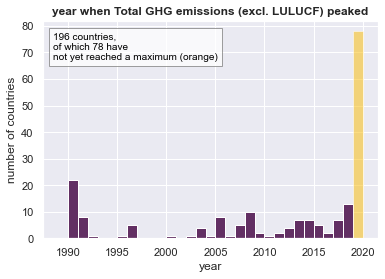

In [16]:
if plot_type == 1:
    #plot_name = 'distribution_of' + variable
    utils.make_histogram(dset_to_plot, year_of_interest, unit, plot_type=1, xlabel=plot_type_text, variable_title=variable, sourcename=source, filepath=plot_fname, remove_outliers=True, plot_name=plot_name)
elif plot_type == 2:
    # run calculations - dataframe of differences in all years relative to the specified year
    # the function returns both absolute and relative (%) values
    #if baseline_year >= year_of_interest:
    #    print('Error: The baseline year is greater than the year of interest.')
    #else:
    df_abs_diff_baseline, df_perc_diff_baseline = utils.calculate_diff_since_yearX(dset_to_plot, baseline_year)

    utils.make_histogram(df_perc_diff_baseline, year_of_interest, unit, plot_type=2, xlabel=plot_type_text, variable_title=variable, sourcename=source, filepath=plot_fname, remove_outliers=True, plot_name=plot_name)
elif plot_type == 3:
    trends, rolling_trends, trends_unit = utils.calculate_trends(dset_to_plot, num_years_trend=5)
#trends_variable = 'average annual change'
#thistitle = "5-year rolling average trend in \n" + variable_name_to_display + "\nin " + str(data_years.columns[-1])
    
    utils.make_histogram(rolling_trends, year_of_interest, trends_unit, plot_type=3, xlabel=plot_type_text, variable_title='5-year rolling average trend in ' + variable, sourcename=source, filepath=plot_fname, remove_outliers=True, plot_name=plot_name, ktuk=2)
# make a plot showing the trend in the final year of available data
elif plot_type == 4:

    utils.make_histogram_peaking(year_max, variable, '', start_year, end_year, save_plot=False)


else:
    print('Error. Please provide a valid plot type.')


In [17]:
# Interrogate the data with different conditions (peak year, decreasing rate) to categorise countries  
nyears = 5
n_trend_years = 5
decrease_threshold = -1.5
# set up a dataframe to store analysis results
peaking_assessment = pd.DataFrame()
peaking_assessment['max year'] = year_max
  

# Identify countries that have 'peaked' before the time period chosen by the user above (n years ago)
peaking_assessment['max_reached'] = peaking_assessment['max year'].apply(
                                                                lambda x : (x < (end_year - nyears)))

# Identify countries with decreasing emissions trends
recent_trends, recent_trends_rolling, unit = utils.calculate_trends(dset_to_plot, num_years_trend=n_trend_years)
peaking_assessment['trend'] = recent_trends_rolling[str(end_year)]

peaking_assessment['decreasing'] = peaking_assessment['trend'].apply(lambda x: (x < 0))
peaking_assessment['strongly_decreasing'] = peaking_assessment['trend'].apply(lambda x: (x < decrease_threshold))
peaking_assessment['stable'] = peaking_assessment['trend'].apply(lambda x: (decrease_threshold < x < 0.5))


# Use multi-criteria to define different regimes
# First, the clear cases...
peaking_assessment['peaked']     = peaking_assessment['max_reached'] & \
                                   peaking_assessment['strongly_decreasing']

peaking_assessment['stabilised'] = (peaking_assessment['max_reached'] & \
                                    peaking_assessment['stable']) | \
                                   ((peaking_assessment['max_reached']==False) & \
                                    (peaking_assessment['strongly_decreasing']))

peaking_assessment['not_peaked'] = (peaking_assessment['stabilised']==False) & \
                                   (peaking_assessment['peaked']==False)


# Get stats of shares
share_peaked     = peaking_assessment['peaked'].value_counts(normalize=True) 
share_stabilised = peaking_assessment['stabilised'].value_counts(normalize=True)
share_increasing = peaking_assessment['not_peaked'].value_counts(normalize=True)
check_total = share_peaked[True] + share_stabilised[True] + share_increasing[True]


# and print to screen...
print('')
print('Share of countries peaked is {:.1f}%'.format(share_peaked[True]*100))
print('Share of countries stabilised is {:.1f}%'.format(share_stabilised[True]*100))
print('Share of countries not peaked or stabilised is {:.1f}%'.format(share_increasing[True]*100))
print('Total is: {:.1f}%'.format(check_total*100))
print('')

Averaging trend over 5 years.

Share of countries peaked is 8.7%
Share of countries stabilised is 22.4%
Share of countries not peaked or stabilised is 68.9%
Total is: 100.0%



In [18]:
# Make a plot to summarise how many countries fall into each group.

# count the number of countries in each category
number_peaked     = peaking_assessment['peaked'].value_counts(normalize=False) 
number_stabilised = peaking_assessment['stabilised'].value_counts(normalize=False)
number_increasing = peaking_assessment['not_peaked'].value_counts(normalize=False)
total_countries = number_peaked[True] + number_stabilised[True] + number_increasing[True]

# define new dataframe
summary_data = pd.DataFrame({'category': ['peaked', 'stabilised', 'not peaked'],
                             'count': [number_peaked[True],  number_stabilised[True], number_increasing[True]]})

# make the plot
utils.peaking_barplot(summary_data, variable, str(end_year), save_plot=True)

In [19]:
# And make some plots to view and check the results. 


"""
These functions will plot facet grids of the emissions trends and absolute emissions
for all countries in each category. 

Note that this can take quite some time to run! 
"""


# 1. Peaking
# prep data for plotting 
peaked_country_trends = recent_trends_rolling[peaking_assessment['peaked']]
peaked_country_abs = dset_to_plot[peaking_assessment['peaked']] 

# make the plots
utils.plot_facet_grid_countries(peaked_country_trends, 'year', '% change', 
                          main_title='Countries with peaked emissions', 
                          plot_name=('peaked-' + variable), save_plot=True)

utils.plot_facet_grid_countries(peaked_country_abs, 'year', 'emissions', 
                          main_title='Absolute emissions for peaked countries', 
                          plot_name=('peaked-' + variable), save_plot=True)

    
# 2. Stabilised
stab_trends = recent_trends_rolling[peaking_assessment['stabilised']]
stab_abs    = dset_to_plot[peaking_assessment['stabilised']] 

utils.plot_facet_grid_countries(stab_trends, 'year', '% change', 
                         main_title='Trends in countries with stabilised emissions', 
                         plot_name=('stabilised-' + variable), save_plot=True)
utils.plot_facet_grid_countries(stab_abs, 'year', 'emissions', 
                         main_title='Emissions in countries with stabilised emissions', 
                         plot_name=('stabilised-' + variable), save_plot=True)

# 3. still increasing
not_peaked_trends = recent_trends_rolling[peaking_assessment['not_peaked']]
not_peaked_abs    = dset_to_plot[peaking_assessment['not_peaked']] 

utils.plot_facet_grid_countries(not_peaked_trends, 'year', '% change', 
                         main_title='Trends in countries with emissions that have not yet peaked',
                         plot_name=('not-peaked-' + variable),
                         save_plot=True)
utils.plot_facet_grid_countries(not_peaked_abs, 'year', 'emissions', 
                         main_title='Emissions in countries with emissions that have not yet peaked', 
                         plot_name=('not-peaked-' + variable),
                         save_plot=True)